# MSDS Thesis
## Data Analysis in Python for olfactoneuroimaging data

Apoorv Saraogee MSDS 599 - Dr. Srinivasan

In [5]:
import pandas as pd
import numpy as np
import os

from io import StringIO
import gc

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.image import mean_img
import glob

## Event-handling for positive/negative from each subject and each run

In [68]:
#Example trial_type for one subject and the time to DICOM volume in the matrix
events_df = pd.read_csv('ds002185-download/sub-05/func/sub-05_task-odors_run-01_events.tsv', delimiter='\t')
#The time variable in the matrix refers to dicom volumes, and are found using the MRI repition time or TR of 1.5s
tr = 1.5
events_df['dicom_volume'] = (events_df['onset'] / tr).round().astype(int)
events_df.sort_values(by='onset')

,onset,duration,trial_type,response,dicom_volume
0,13.3,2.1,orange,3,9
15,40.7,1.2,asafetida,1,27
5,73.6,2.0,smelly-cheese,1,49
10,104.1,1.7,banana,2,69
1,133.3,2.5,orange,3,89
16,164.1,2.0,asafetida,1,109
11,195.3,1.9,banana,3,130
6,222.2,1.6,smelly-cheese,2,148
12,251.7,1.3,banana,3,168
2,278.6,2.2,orange,4,186


In [69]:
# Define positive and negative response conditions
positive_conditions = ['orange', 'banana']
negative_conditions = ['isovaleric', 'bacon', 'asafetida', 'smelly-cheese']

# TR value
tr = 1.5

# Function to process events, filter by condition, and extract 4D data for 16 DICOM volumes after onset
def process_and_extract_data(file_path, nifti_file):
    # Extract subject and run from the file path
    parts = file_path.split('/')
    subject = parts[1]
    filename = os.path.basename(file_path)
    run_modality = filename.split('_')[2].replace('_events.tsv', '')  # Extract run_modality as 'run-01' or 'run-02'

    if run_modality not in ['run-01', 'run-02']:
        raise ValueError(f"Unexpected run_modality: {run_modality}")

    # Skip specific conditions: sub-22 run-01 and sub-21 all runs
    if (subject == 'sub-22' and run_modality == 'run-01') or (subject == 'sub-21'):
        print(f"Skipping subject {subject} run {run_modality}")
        return pd.DataFrame()  # Return an empty DataFrame and skip processing

    # Load the events.tsv file into a DataFrame
    events_df = pd.read_csv(file_path, delimiter='\t')

    # Check for 'trial_type' or 'condition' and rename to 'smell'
    if 'trial_type' in events_df.columns:
        events_df.rename(columns={'trial_type': 'smell'}, inplace=True)
    elif 'condition' in events_df.columns:
        events_df.rename(columns={'condition': 'smell'}, inplace=True)
    else:
        print(f"'trial_type' or 'condition' column not found in file: {file_path}. Adding 'smell' column with default value.")
        events_df['smell'] = 'unknown'  # Add 'smell' column with a default value if neither column is found

    # Convert onset to DICOM volume
    events_df['onset'] = events_df['onset'].astype(float)
    events_df['dicom_volume'] = (events_df['onset'] / tr).round().astype(int)

    # Classify as positive or negative
    events_df['response_type'] = 'positive'
    events_df.loc[events_df['smell'].isin(negative_conditions), 'response_type'] = 'negative'

    # Filter based on condition (either positive or negative)
    filtered_df = events_df[events_df['smell'].isin(positive_conditions + negative_conditions)].copy()

    if filtered_df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid events

    # Create a list to store the data for each event
    extracted_data = []

    for _, row in filtered_df.iterrows():
        dicom_start = row['dicom_volume']
        dicom_end = dicom_start + 16

        # Load the image slice by slice (memory-efficient)
        img = nib.load(nifti_file, mmap=True)  # Memory-map the NIfTI file
        _, _, _, num_volumes = img.shape

        # Check if there are enough volumes to extract
        if dicom_start >= 0 and dicom_end <= num_volumes:
            # Extract the 4D data for the 16 volumes starting from the onset
            data_slice = img.dataobj[:, :, :, dicom_start:dicom_end]

            # Only add to list if data_slice has at least 16 volumes
            if data_slice.shape[-1] >= 16:
                extracted_data.append({
                    'subject': subject,
                    'run_modality': run_modality,
                    'onset': row['onset'],
                    'dicom_start': dicom_start,
                    'dicom_end': dicom_end,
                    'smell': row['smell'],
                    'response_type': row['response_type'],  # Add response type column
                    'idno': f"{subject}_{run_modality}_{dicom_start}_{row['smell']}",  # Add ID column
                    'data': np.copy(data_slice)  # Use np.copy to avoid referencing the memory-mapped array
                })
            else:
                print(f"Skipping event with fewer than 16 volumes: Start = {dicom_start}, End = {dicom_end}, Total Volumes = {num_volumes}")
        else:
            print(f"Skipping event with invalid DICOM volume range: Start = {dicom_start}, End = {dicom_end}, Total Volumes = {num_volumes}")

    # Explicitly delete variables and force garbage collection
    del img, events_df, filtered_df
    gc.collect()

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(extracted_data)

# Process all subjects and runs for both positive and negative responses
event_files = glob.glob('ds002185-download/sub-*/func/*_events.tsv')
combined_dfs = []

for file_path in event_files:
    # Assume the corresponding NIfTI file is named similarly to the events file
    nifti_file = file_path.replace('_events.tsv', '_bold_preprocessed.nii.gz')

    # Check if the NIfTI file exists
    if not os.path.exists(nifti_file):
        print(f"NIfTI file not found: {nifti_file}")
        continue  # Skip this file if it doesn't exist

    try:
        # Process both positive and negative responses
        combined_df = process_and_extract_data(file_path, nifti_file)

        # Append to the combined list if the DataFrame is not empty
        if not combined_df.empty:
            combined_dfs.append(combined_df)

        # Print a statement after every file is processed
        print(f"Processed file: {file_path}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

    # Force garbage collection after each file is processed
    gc.collect()

# Combine all subjects into a single DataFrame for both positive and negative responses
if combined_dfs:
    combined_df = pd.concat(combined_dfs, ignore_index=True)
else:
    combined_df = pd.DataFrame()

# Print total number of events
print(f"Total number of events (positive + negative): {len(combined_df)}")

# Display the combined DataFrame
print("Combined Events DataFrame:")
print(combined_df.head())

# Define the path to the README file
readme_path = os.path.join('ds002185-download', 'README')

# Read the README file
with open(readme_path, 'r') as file:
    readme_contents = file.read()

# Extract content starting from "column1" until the end
start_marker = 'column1:'
start_index = readme_contents.find(start_marker)

if start_index != -1:
    extracted_section_text = readme_contents[start_index:].strip()
    # Parse the extracted section into a DataFrame
    extracted_section = pd.read_csv(StringIO(extracted_section_text), delimiter='\t', header=None,
                                    names=['subject', 'run01_skip', 'run01_dicoms', 'run02_skip', 'run02_dicoms'])
else:
    raise ValueError("The start marker 'column1' not found in the README file.")

# Print the total number of events before filtering
print(f"Total number of events before filtering: {len(combined_df)}")

def filter_by_dicom_start(df, extracted_section):
    filtered_dfs = []
    for _, row in df.iterrows():
        subject = row['subject']
        run_modality = row['run_modality']
        dicom_start = row['dicom_start']

        # Retrieve skip threshold for the given subject and run modality
        if run_modality == 'run-01':
            skip_threshold = extracted_section.loc[extracted_section['subject'] == subject, 'run01_skip'].values
        elif run_modality == 'run-02':
            skip_threshold = extracted_section.loc[extracted_section['subject'] == subject, 'run02_skip'].values
        else:
            continue  # Skip if run_modality is not recognized

        if len(skip_threshold) == 0:
            print(f"No skip threshold found for subject {subject} and modality {run_modality}.")
            continue

        skip_threshold = skip_threshold[0]  # Extract the threshold value

        # Filter out events where dicom_start is greater than skip_threshold
        if dicom_start >= skip_threshold:
            filtered_dfs.append(row)

    # Convert filtered rows into a DataFrame
    if filtered_dfs:
        return pd.DataFrame(filtered_dfs)
    else:
        return pd.DataFrame(columns=df.columns)

# Apply the filtering function to the combined DataFrame
filtered_combined_df = filter_by_dicom_start(combined_df, extracted_section)

# Print the total number of positive events after filtering
print(f"Total number of positive events after filtering: {len(filtered_combined_df)}")
# Print the columns of the DataFrames to confirm
print("DataFrame columns:", filtered_combined_df.columns)


Processed file: ds002185-download/sub-13/func/sub-13_task-odors_run-02_events.tsv
Processed file: ds002185-download/sub-13/func/sub-13_task-odors_run-01_events.tsv
Processed file: ds002185-download/sub-14/func/sub-14_task-odors_run-01_events.tsv
Processed file: ds002185-download/sub-14/func/sub-14_task-odors_run-02_events.tsv
Skipping event with invalid DICOM volume range: Start = 433, End = 449, Total Volumes = 440
Processed file: ds002185-download/sub-22/func/sub-22_task-odors_run-02_events.tsv
NIfTI file not found: ds002185-download/sub-22/func/sub-22_task-odors_run-01_bold_preprocessed.nii.gz
Processed file: ds002185-download/sub-15/func/sub-15_task-odors_run-02_events.tsv
Processed file: ds002185-download/sub-15/func/sub-15_task-odors_run-01_events.tsv
Processed file: ds002185-download/sub-12/func/sub-12_task-odors_run-01_events.tsv
Processed file: ds002185-download/sub-12/func/sub-12_task-odors_run-02_events.tsv
Processed file: ds002185-download/sub-08/func/sub-08_task-odors_run-

## Visualizing Cleaned Images for an Example

Viewing mean image for the selected positive event


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



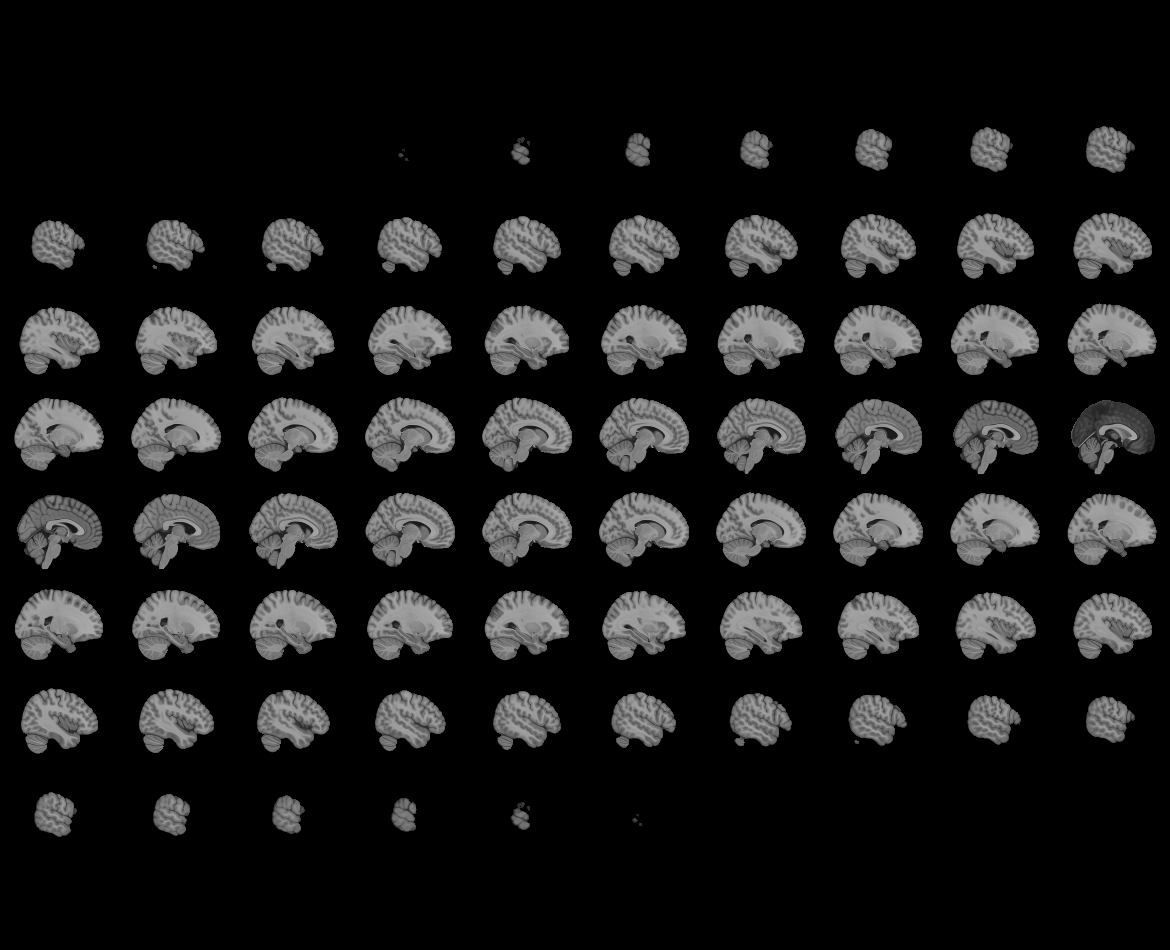
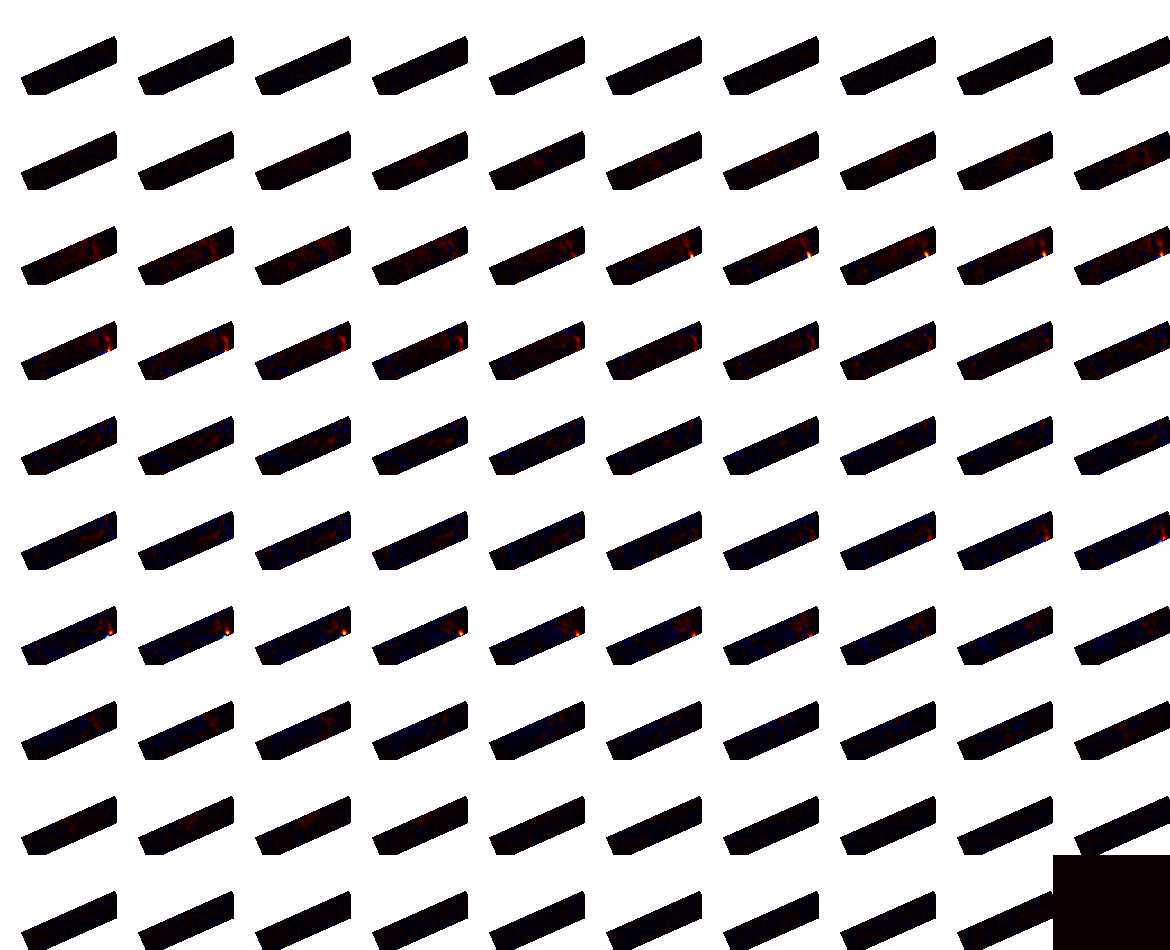

In [70]:
# Define the subject and run
subject = 'sub-01'
run_modality = 'run-02'

# Filter the DataFrames based on subject and run_modality
onerun_df = filtered_combined_df[(filtered_combined_df['subject'] == subject) & (filtered_combined_df['run_modality'] == run_modality)]

# Check if the filtered DataFrame is not empty
if not onerun_df.empty:
    # Get the data for the first event that matches the subject and run
    positive_data = onerun_df.iloc[0]['data']
    negative_data = onerun_df.iloc[0]['data']
else:
    print(f"No data available for the specified subject ({subject}) and run_modality ({run_modality}).")


# Define the NIfTI file path based on subject and run
nifti_file = f'ds002185-download/{subject}/func/{subject}_task-odors_{run_modality}_bold_preprocessed.nii.gz'

# Check if the file exists
if os.path.exists(nifti_file):
    # Load the NIfTI file
    img = nib.load(nifti_file)
    
    # Extract the affine transformation matrix
    affine = img.affine

# Convert the extracted data to NIfTI images if needed
positive_img = nib.Nifti1Image(positive_data, affine)
# Convert the extracted data to NIfTI images if needed
negative_img = nib.Nifti1Image(negative_data, affine)

# Compute the mean image using nilearn
mean_positive_img = mean_img(positive_img)
# Compute the mean image using nilearn
mean_negative_img = mean_img(negative_img)

# View the mean image for an example positive
print("Viewing mean image for the selected positive event")
plotting.view_img(mean_positive_img, threshold=None, title='Mean Image for Selected Positive Event - Subject 01')


Viewing mean image for the selected negative event


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



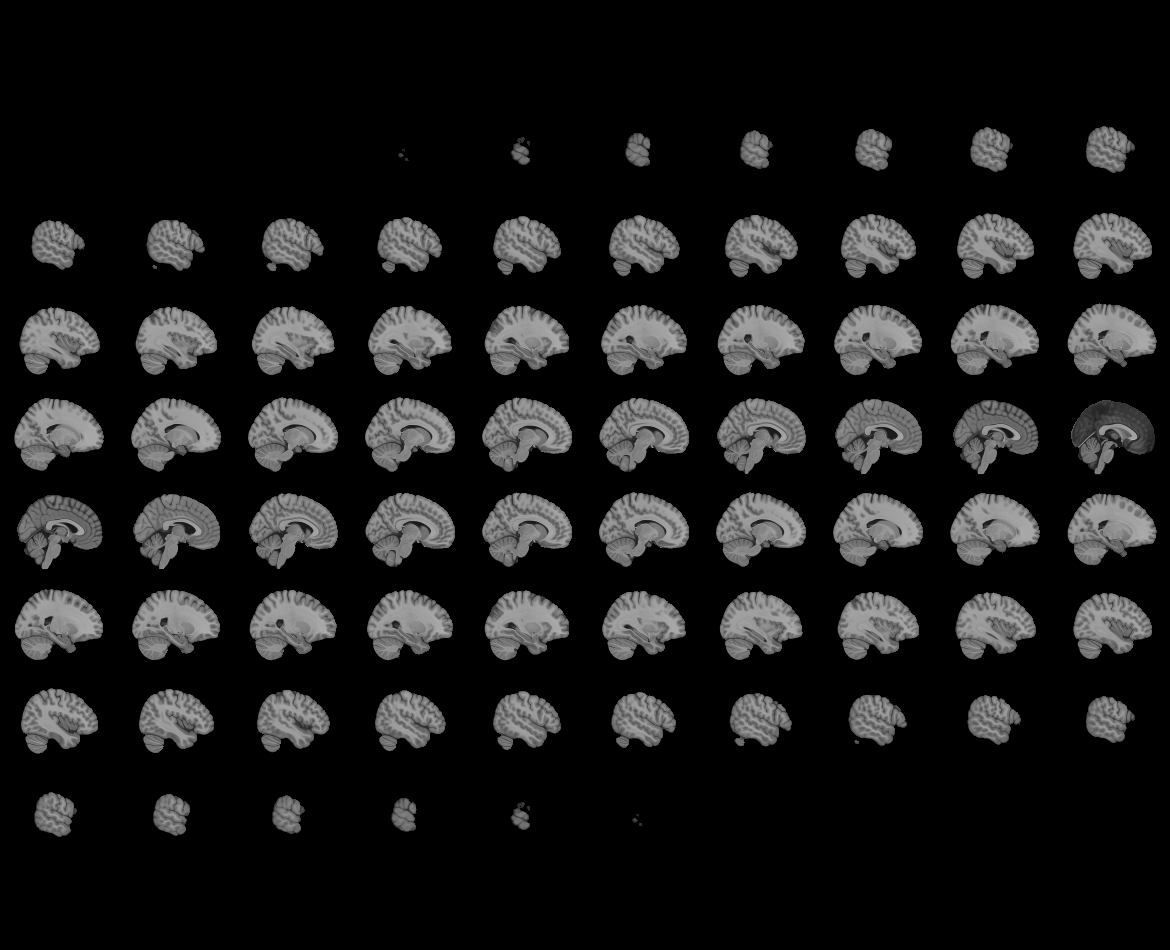
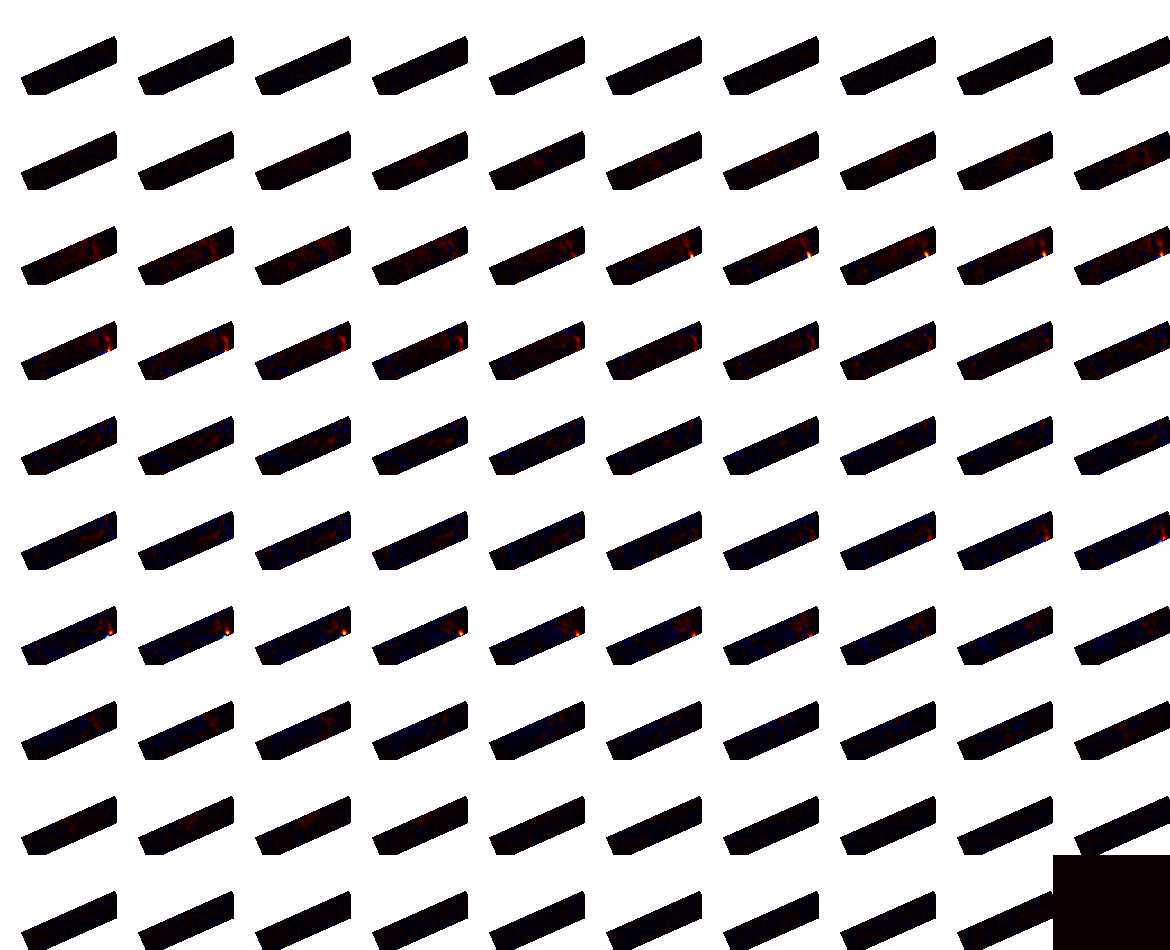

In [71]:
# View the mean image for an example negative
print("Viewing mean image for the selected negative event")
plotting.view_img(mean_negative_img, threshold=None, title='Mean Image for Selected Negative Event - Subject 01')

## Saving output dataframe into a pickle file

In [72]:
# Save the final filtered DataFrame to a pickle file
output_pickle_file = 'filtered_events.pkl'
filtered_combined_df.to_pickle(output_pickle_file)
print(f"Filtered events DataFrame saved to: {output_pickle_file}")

# Delete the variable to free memory
del filtered_combined_df
gc.collect()

print("filtered_combined_df deleted and memory cleared.")

Filtered events DataFrame saved to: filtered_events.pkl
filtered_combined_df deleted and memory cleared.
